# Machine Learning at Scale, Part I

## KMeans clustering at scale

Training models with data that fits in memory is very limiting. But minibatch learners can easily work with data directly from disk. 

We'll use the MNIST data set, which has 8 million images (about 17 GB). The dataset has been partition into groups of 100k images (using the unix split command) and saved in compressed lz4 files. This dataset is very large and doesnt get loaded by default by <code>getdata.sh</code>. You have to load it explicitly by calling <code>getmnist.sh</code> from the scripts directory. The script automatically splits the data into files that are small enough to be loaded into memory. 

Let's load BIDMat/BIDMach

In [1]:
import BIDMat.{CMat,CSMat,DMat,Dict,IDict,Image,FMat,FND,GDMat,GMat,GIMat,GSDMat,GSMat,HMat,IMat,Mat,SMat,SBMat,SDMat}
import BIDMat.MatFunctions._
import BIDMat.SciFunctions._
import BIDMat.Solvers._
import BIDMat.Plotting._
import BIDMach.Learner
import BIDMach.models.{FM,GLM,KMeans,KMeansw,ICA,LDA,LDAgibbs,Model,NMF,RandomForest,SFA}
import BIDMach.datasources.{DataSource,MatSource,FileSource,SFileSource}
import BIDMach.mixins.{CosineSim,Perplexity,Top,L1Regularizer,L2Regularizer}
import BIDMach.updaters.{ADAGrad,Batch,BatchNorm,IncMult,IncNorm,Telescoping}
import BIDMach.causal.{IPTW}

Mat.checkMKL
Mat.checkCUDA
Mat.inline = true
if (Mat.hasCUDA > 0) GPUmem

1 CUDA device found, CUDA version 7.0


(0.8549279,10327015424,12079398912)

And define the root directory for this dataset.

In [2]:
val mdir = "../data/MNIST8M/parts/"

../data/MNIST8M/parts/

The files we need are named "alls00.fmat.lz4", "alls01.fmat.lz4" etc. We can create a learner using a pattern for accessing these files:

In [3]:
val (mm, opts) = KMeans.learner(mdir+"alls%02d.fmat.lz4",1024)

BIDMach.models.KMeans$FileOptions@f10756e

The string "%02d" is a C/Scala format string that expands into a two-digit ASCII number to help with the enumeration.

There are several new options that can tailor a files datasource, but we'll mostly use the defaults. One thing we will do is define the last file to use for training (number 70). This leaves us with some held-out files to use for testing. 

In [4]:
opts.nend = 10

10

Note that the training data include image data and labels (0-9). K-Means is an unsupervised algorithm and if we used image data only KMeans will often build clusters containing different digit images. To produce cleaner clusters, and to facilitate classification later on, the <code>alls</code> data includes both labels in the first 10 rows, and image data in the remaining rows. The label features are scaled by a large constant factor. That means that images of different digits will be far apart in feature space. It effectively prevents different digits occuring in the same cluster. 

## Tuning Options

The following options are the important ones for tuning. For KMeans, batchSize has no effect on accracy since the algorithm uses all the data instances to perform an update. So you're free to tune it for best speed. Generally larger is better, as long as you dont use too much GPU ram. 

npasses is the number of passes over the dataset. Larger is typically better, but the model may overfit at some point. 

In [5]:
opts.batchSize = 20000
opts.npasses = 4

4

You invoke the learner the same way as before. You can change the options above after each run to optimize performance. 

In [6]:
mm.train

pass= 0
First pass random centroid initialization
 4.00%, ll=0.00000, gf=47.824, secs=0.7, GB=0.13, MB/s=186.28, GPUmem=0.814831
25.00%, ll=0.00000, gf=19.074, secs=3.4, GB=0.83, MB/s=241.45, GPUmem=0.814300
48.00%, ll=0.00000, gf=18.760, secs=5.2, GB=1.52, MB/s=292.27, GPUmem=0.814213
70.00%, ll=0.00000, gf=19.718, secs=6.6, GB=2.22, MB/s=335.98, GPUmem=0.814126
91.00%, ll=0.00000, gf=19.441, secs=8.4, GB=2.92, MB/s=348.30, GPUmem=0.814039
100.00%, ll=0.00000, gf=22.804, secs=8.6, GB=3.18, MB/s=370.08, GPUmem=0.814039
pass= 1
 4.00%, ll=-2455844.25000, gf=32.047, secs=9.2, GB=3.30, MB/s=360.59, GPUmem=0.806986
25.00%, ll=-2480660.50000, gf=98.438, secs=9.9, GB=4.00, MB/s=402.63, GPUmem=0.806986
48.00%, ll=-2458841.25000, gf=155.994, secs=10.7, GB=4.70, MB/s=440.86, GPUmem=0.806986
70.00%, ll=-2458864.25000, gf=206.221, secs=11.4, GB=5.40, MB/s=474.20, GPUmem=0.806986
91.00%, ll=-2479250.25000, gf=250.195, secs=12.1, GB=6.10, MB/s=503.05, GPUmem=0.806986
100.00%, ll=-2459399.00000, gf=

Now lets extract the model as a Floating-point matrix. We included the category features for clustering to make sure that each cluster is a subset of images for one digit. 

In [7]:
val modelmat = FMat(mm.modelmat)

      0      0      0      0      0      0      0  10000      0      0...
      0      0      0      0      0      0  10000      0      0      0...
      0      0      0      0  10000      0      0      0      0      0...
  10000      0      0      0      0      0      0      0      0      0...
      0      0      0      0  10000      0      0      0      0      0...
      0      0      0  10000      0      0      0      0      0      0...
      0  10000      0      0      0      0      0      0      0      0...
      0      0      0      0      0  10000      0      0      0      0...
     ..     ..     ..     ..     ..     ..     ..     ..     ..     ..


Next we build a 30 x 10 array of images to view the first 300 cluster centers as images.

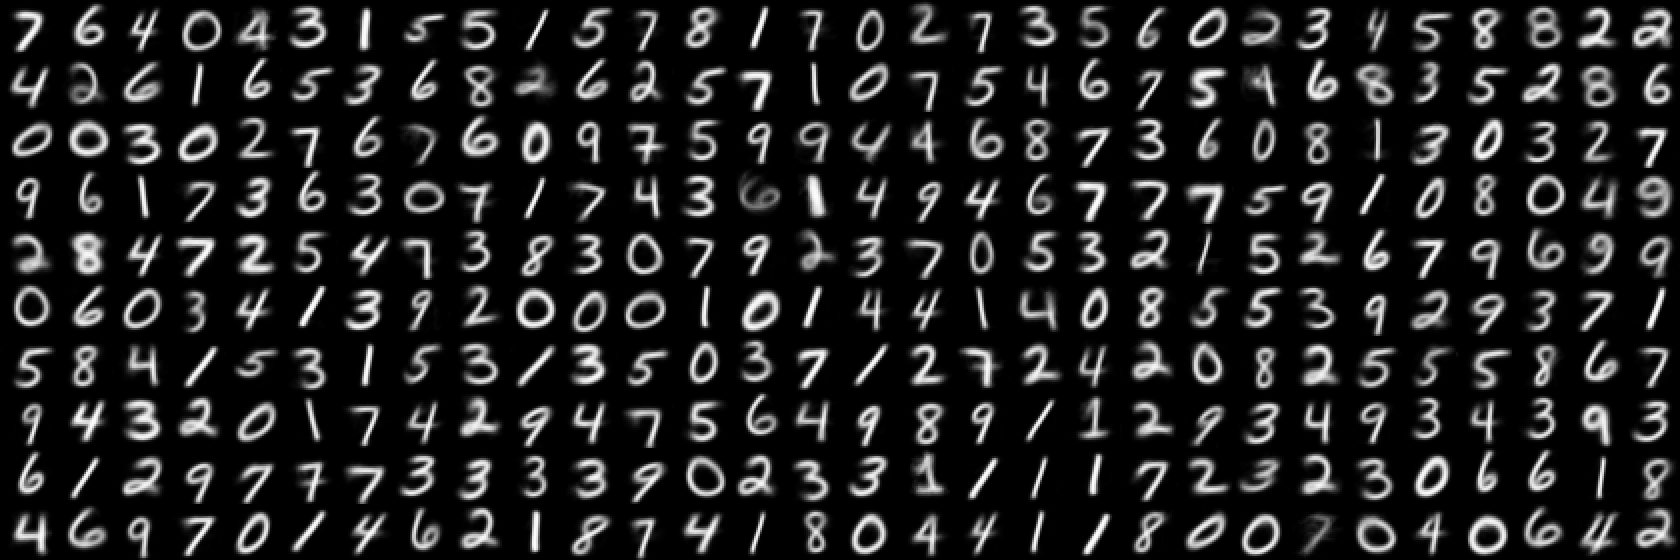

In [8]:
val nx = 30
val ny = 10
val im = zeros(28,28)
val allim = zeros(28*nx,28*ny)
for (i<-0 until nx) {
    for (j<-0 until ny) {
        val slice = modelmat(i+nx*j,10->794)
        im(?) = slice(?)
        allim((28*i)->(28*(i+1)), (28*j)->(28*(j+1))) = im
    }
}
show(allim kron ones(2,2))

We'll predict using the closest cluster (or 1-NN if you like). First we read some data directly. We could also try to do evaluation directly from disk, but this would usually be overkill.

In [9]:
val test = loadFMat(mdir+"alls70.fmat.lz4")   // Load a test data file
val testdata = test.copy                      // copy it
testdata(0->10,?) = 0                         // and remove the digit labels
1                                             // avoids a monster data cell being printed

1

Next we define a predictor from the just-computed model and the testdata, with the preds matrix to catch the predictions.

In [10]:
val (pp, popts) = KMeans.predictor(mm.model, testdata)

BIDMach.models.KMeans$PredOptions@169d1ef0

Lets run the predictor

In [11]:
pp.predict 

Predicting


scala.MatchError: null

The <code>preds</code> matrix now contains the numbers of the best-matching cluster centers. We still need to look up the category label for each one. We also need to look up the category for each of the test inputs.

In [12]:
val (vmax, predcat) = maxi2(modelmat(preds,0->10).t)   // Lookup the cat for the matching cluster
val (wmax, truecat) = maxi2(test(0->10,?))             // Reference cats for test items
val inds = predcat.t \ truecat.t                       // Concatenate them into a two-column matrix

: 

From the actual and predicted categories, we can compute a confusion matrix:

In [13]:
val conf = accum(inds, 1f, 10, 10)  // accumulate the (estimate,exact) ids into a matrix
conf ~ conf / sum(conf)             // normalize

: 

Now lets create an image by multiplying each confusion matrix cell by a white square:

In [14]:
Image.show((conf * 250f) ⊗ ones(64,64))

: 

Its useful to isolate the correct classification rate by digit, which is:

In [15]:
val dacc = getdiag(conf).t

: 

We can take the mean of the diagonal accuracies to get an overall accuracy for this model. 

In [16]:
mean(dacc)

: 

Run the experiment again with a larger number of clusters (3000, then 30000). You should reduce the batchSize option to 20000 to avoid memory problems.

Include the training time output by the call to <code>nn.train</code> but not the evaluation time (the evaluation code above is not using the GPU). Rerun and fill out the table below: 

<table>
<tr>
<th>KMeans Clusters</th>
<th>Training time</th>
<th>Avg. gflops</th>
<th>Accuracy</th>
</tr>
<tr>
<td>300</td>
<td>...</td>
<td>...</td>
<td>...</td>
</tr>
<tr>
<td>3000</td>
<td>...</td>
<td>...</td>
<td>...</td>
</tr>
<tr>
<td>30000</td>
<td>...</td>
<td>...</td>
<td>...</td>
</tr>
</table>

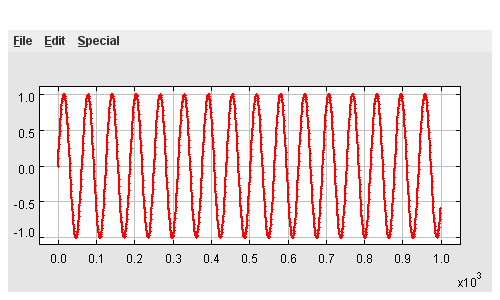

In [17]:
val ii = row(0->1000)*0.1f
val p=plot(sin(ii))